In [ ]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import torchvision.models as models
from torch.autograd import Variable
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import time as time_calc
import requests
from PIL import Image, ImageDraw
from io import BytesIO
import pandas as pd
import os

Mounted at /content/drive


### Introduction

In this notebook I implement a diffusion model to generate images from the MNIST fashion dataset. The model follows that described in https://arxiv.org/pdf/2006.11239.pdf, with some architectural changes (attention and residual connections).


In [ ]:
IMG_SIZE = 28
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# Code for the training loop goes here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

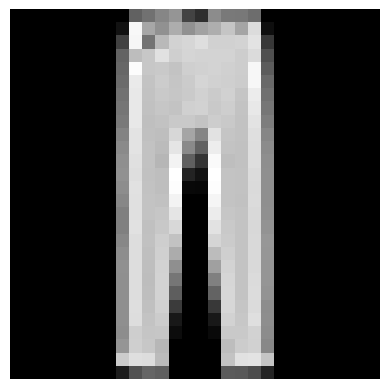

In [ ]:
data_iter = iter(dataloader)
batch = next(data_iter)

# Get one image from the batch
image = batch["pixel_values"][0]  # Assuming batch dimension is first

# Plot the image
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

The following helper functions will be useful. In particular, whenever we input a vector (list) of values, this will help to select the right time t output. We will use this in the sampling loops.

In [ ]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    Returns a VALUE not an index
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##### The noising process

Our first step will be to implement the forward process that adds noise to an image.

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$.

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$.

Test the function on an image from the dataset using the given code below.

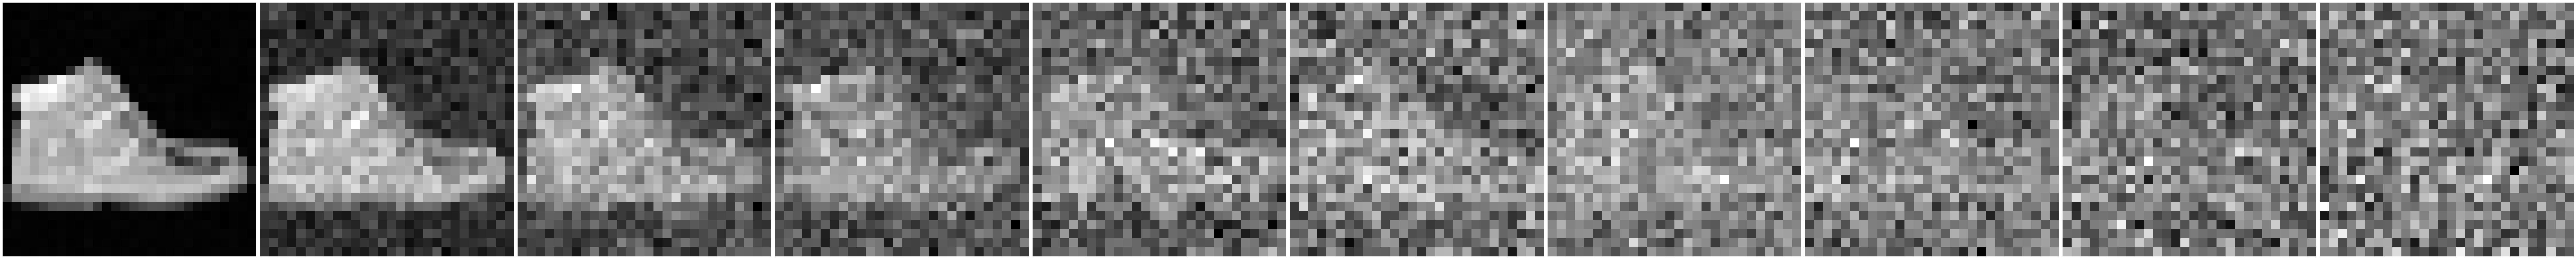

In [ ]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    '''
    output a vector of size timesteps that is equally spaced between start and end; this will be the noise that is added in each time step.
    '''
    return torch.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    Hint: use the get_index_from_list function to select the right values at time t.
    """
    # Getting sqrt_alphas_cumprod & sqrt_one_minus_alphas_cumprod for t
    sqrt_alphas_cumprod = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)

    # Generating random noise of size of image
    noise = torch.randn(x_0.shape).to(device)

    # Noisy Image
    x_t = sqrt_alphas_cumprod*x_0 + sqrt_one_minus_alphas_cumprod*noise

    return x_t.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# ADD HERE THE COMPUTATIONS NEEDED for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod

alphas = 1.- betas
alpha_bar = torch.cumprod(alphas, dim=0)
alpha_bar_prev = torch.cat((torch.tensor([1.]), alpha_bar[:-1]))
sqrt_alphas_cumprod  = torch.sqrt(alpha_bar)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.- alpha_bar)

# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

plt.figure(figsize=(250, 250))

subplot_width = 100  # Adjust the width of each subplot
subplot_height = 100

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

    # Plot the image
    plt.subplot(1, num_images, idx // stepsize + 1)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    plt.axis('off')  # Turn off axis
    plt.gcf().set_size_inches(subplot_width, subplot_height)

plt.tight_layout()
plt.show()

Below I play around with the noise (compare two different beta schedules) and present results for the two setting

In [ ]:
# Different Beta Schedulers

def diff_betas(timesteps, start=0.0001, end=0.02):
  betas = linear_beta_schedule(timesteps, start = start, end=end)
  alphas = 1.- betas
  alpha_bar = torch.cumprod(alphas, dim=0)
  alpha_bar_prev = torch.cat((torch.tensor([1.]), alpha_bar[:-1]))
  sqrt_alphas_cumprod  = torch.sqrt(alpha_bar)
  sqrt_one_minus_alphas_cumprod = torch.sqrt(1.- alpha_bar)

  # Simulate forward diffusion
  batch = next(iter(dataloader))["pixel_values"]
  num_images = 10
  stepsize = int(T/num_images) # 30 step size to get 10 images

  subplot_width = 100  # Adjust the width of each subplot
  subplot_height = 100

  for idx in range(0, T, stepsize):
      t = torch.Tensor([idx]).type(torch.int64)
      img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

      # Plot the image
      plt.subplot(1, num_images, idx // stepsize + 1)
      plt.imshow(img.reshape(28, 28), cmap="gray")
      plt.axis('off')  # Turn off axis
      plt.gcf().set_size_inches(subplot_width, subplot_height)

  plt.tight_layout()
  plt.show()


Example 1;

- No. Timesteps; 300
- Start Value; 0.0001
- End Value; 0.01

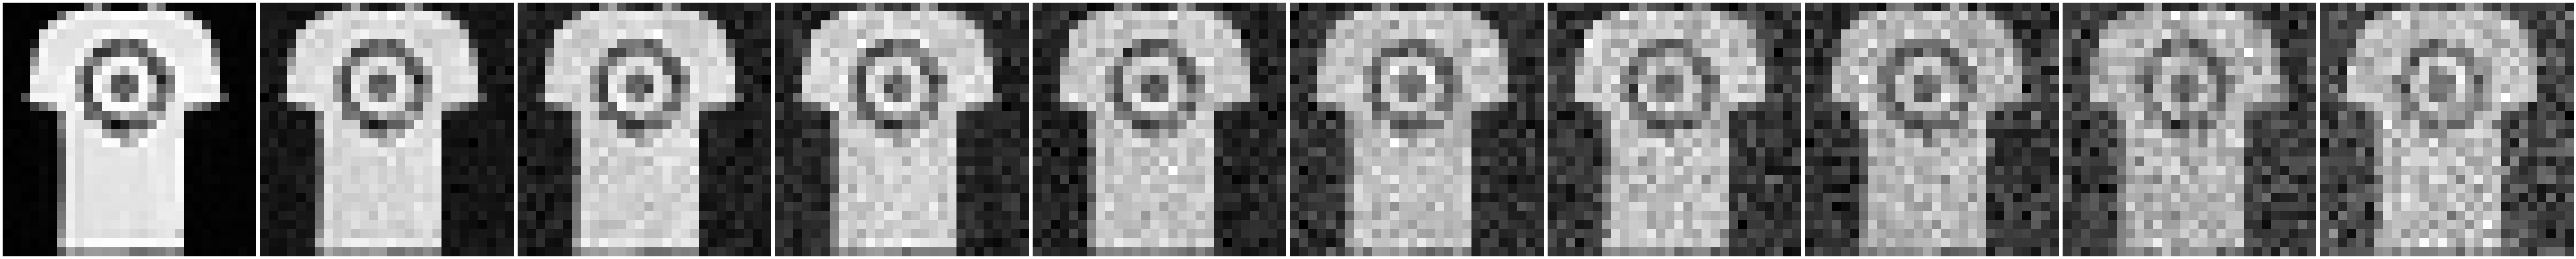

In [ ]:
diff_betas(300, 0.0001, 0.001)

Example 2;
- No. Timesteps; 10000
- Start Value; 0.001
- End Value; 0.02


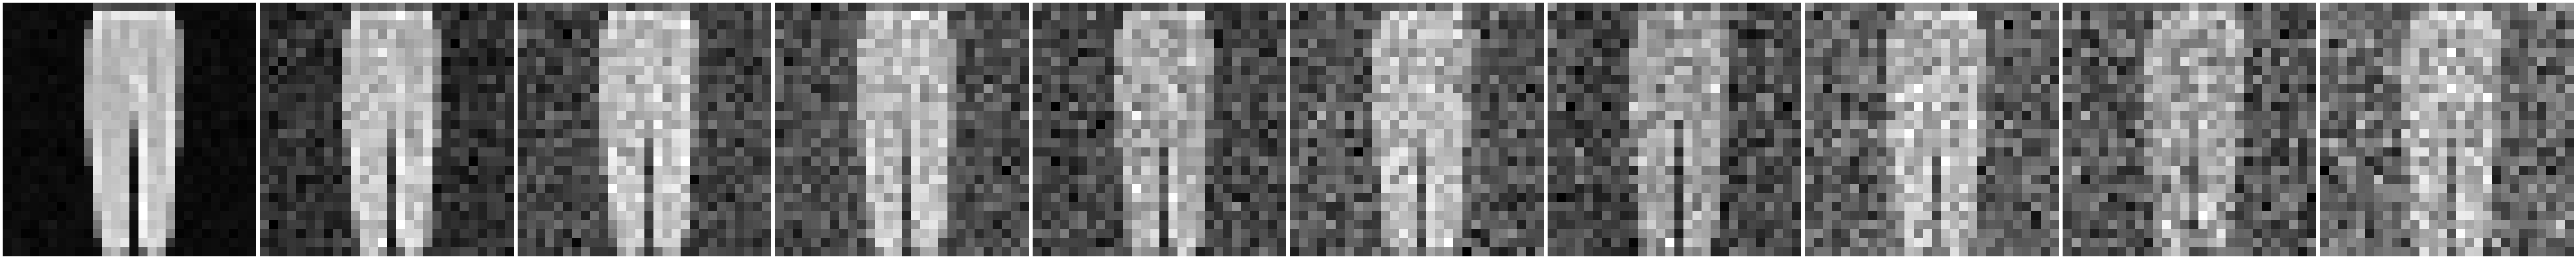

In [ ]:
diff_betas(10000, 0.001, 0.02)

**Noise Scheduler Discussion**

The linear beta scheduler determines noise quantity added in forward sampling. Lower initial values result in less noise per timestep, while more timesteps lead to gradual noise addition due to lower marginal noise per step, as shown above. Adjusting hyperparameters influences the pace and amount of noise introduced during sampling, affecting the opposing forces of model exploration and convergence in training.



**The model for the noise**

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding.

This outputs a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with.

However, we use the following identity to implement:
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        '''
        Fill in the code
        '''
        device = time.device
        batch_size = time.shape[0]
        # times = torch.arange(batch_size)
        # times = time

        dims = torch.arange(self.dim/2, device = device)

        time_expanded = time.unsqueeze(1).to(device)
        dim_expanded = dims.unsqueeze(0).to(device)

        expression = torch.exp(torch.log(time_expanded) - (2*dim_expanded / self.dim) * torch.log(torch.tensor(10000)))

        sin_cos_result = torch.zeros(batch_size, self.dim).to(device)
        sin_cos_result[:, 0::2] = torch.sin(expression)
        sin_cos_result[:, 1::2] = torch.cos(expression)

        return sin_cos_result


Below I visualise the positional embeddings with arbitary time and dimension

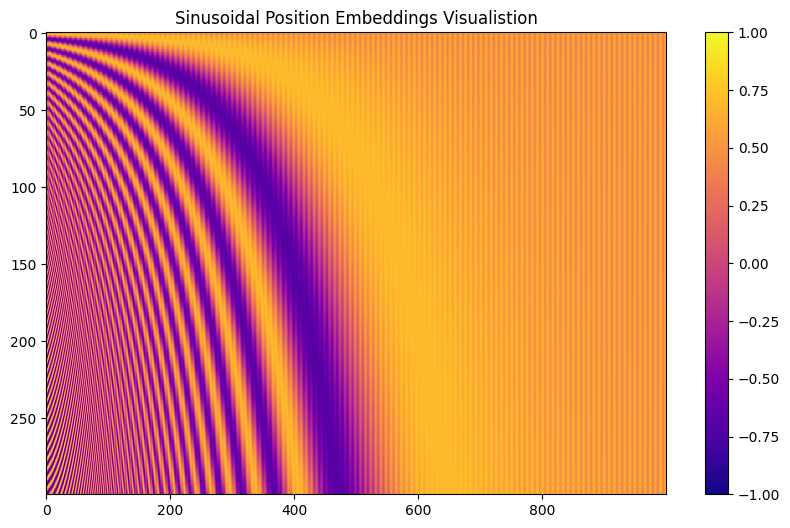

In [ ]:
def visualize_positional_embeddings(positional_embeddings):
    plt.figure(figsize=(10, 6))
    plt.imshow(positional_embeddings, cmap = 'plasma', aspect= 'auto')
    plt.colorbar()
    plt.title('Sinusoidal Position Embeddings Visualistion')
    return

dim = 1000    # Dimension of positional embeddings
T = 300  # Number of time steps

time = torch.arange(T)

positional_embedding_layer = SinusoidalPositionEmbeddings(dim)
positional_embeddings = positional_embedding_layer(time).cpu()
visualize_positional_embeddings(positional_embeddings)



**Positional Encoding Discussion**

In general positional encodings are used to capture positional information of an input sequence. In our case, we want the model to have a unique representation for each level of noise (determined by randomly sampled timestep) we apply to a sampled image.

We use the sinuisodal position encoding matrix as it allows us to allocate a unique vector of length equal to the time embedding to each level of noise.

The uniqueness is a result of the irrational periodicity of the sine and cosine functions. The dimension of our time embedding determines how distinctly each  level of noise will be encoded, allowing for easier recognition by the model.

**U-Net Block**

The UNet architecture utilizes down and up sampling operations for encoding and decoding input images, respectively.

In down sampling blocks, feature extraction occurs through successive 3x3 convolutional layers with ReLU activation, followed by a 4x4 convolutional layer for downsampling. Up sampling blocks reverse these operations to recover the input image.

Time embedding, facilitated by sinusoidal positioning encoding, aids the model in discerning noise levels at each layer. Additionally, upsampling layers involve concatenation operations and may include a middle or bottleneck layer for further processing.

[1.5pt] Use the above code to fill in the code for the UNet below.



[0.5pt] Finally, define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise.

In [ ]:
# Code to make your most efficient setup goes here; present all code from above in one Code block
# run it to show final runtimes and print out the total number of parameters in the mode.

# Efficient Model

model_dir = '/content/drive/My Drive/Foundations_of_ML/CW2/cw_2_model_weights'
os.makedirs(model_dir, exist_ok=True)

class Block_Residual(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, UMD):
        '''
        in_ch refers to the number of channels in the input to the operation
          and out_ch how many should be in the output
        '''
        super().__init__()


        if UMD == 'U':
            self.time_mlp =  nn.Linear(time_emb_dim, in_ch) # Time emb to first up channel
            self.conv1 = nn.Conv2d(2*in_ch, in_ch, 3, padding=1) # Halving channels
            self.resid = nn.Conv2d(2*in_ch, in_ch, 1, padding=0)
            self.conv2 = nn.Conv2d(in_ch, in_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(in_ch, out_ch, kernel_size =  4, stride = 2, padding = 1) # Doubles image size, maintains channels
            self.bnorm1 = nn.BatchNorm2d(in_ch)
            self.bnorm2 = nn.BatchNorm2d(in_ch)

        elif UMD == 'M':
            self.time_mlp = nn.Linear(time_emb_dim, 2*in_ch) # Timb emb to TWICE the last down channel
            self.conv1 = nn.Conv2d(in_ch, 2*in_ch, 3, padding=1) # Doubling channels
            self.resid = nn.Conv2d(in_ch, 2*in_ch, 1, padding=0)
            self.bnorm1 = nn.BatchNorm2d(2*in_ch)
            self.conv2 =  nn.Conv2d(2*in_ch, 2*in_ch, 3, padding=1) # No change image nor channels
            self.bnorm2 = nn.BatchNorm2d(2*in_ch) # This is where Gating g comes from
            self.transform = nn.ConvTranspose2d(2*in_ch, in_ch, 4, 2, 1) # Doubles image size, halves channels

        elif UMD == 'D':
            self.time_mlp = nn.Linear(time_emb_dim, out_ch) # Time emb to down out channel dim
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.resid = nn.Conv2d(in_ch, out_ch, 1, padding=0)
            self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1) # No change image nor channels
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size =  4, stride = 2, padding = 1)
            self.bnorm1 = nn.BatchNorm2d(out_ch)
            self.bnorm2 = nn.BatchNorm2d(out_ch)

        self.relu  = nn.ReLU()

    def forward(self, x, t):
        '''
        Define the forward pass making use of the components above.
        Time t should get mapped through the time_mlp layer + a relu
        The input x should get mapped through a convolutional layer with relu / batchnorm
        The time embedding should get added the output from the input convolution
        A second convolution should be applied and finally passed through the self.transform.
        '''
        # Time Embedding
        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)

        # Conv1 Layer
        h = self.conv1(x)
        h = self.bnorm1(h)
        h = self.relu(h)

        # Residual
        resid = self.resid(x)

        # Adding time embedding
        h = h + time_emb.unsqueeze(2).unsqueeze(3).expand_as(h)

        # Conv2 Layer
        h = self.conv2(h)
        h = self.bnorm2(h)
        h = self.relu(h) + resid
        skip = h

        h = self.transform(h)

        return h, skip

class Attention_Residual(nn.Module):
    def __init__(self, out_ch):
        super(Attention_Residual, self).__init__()

        self.gconv = nn.ConvTranspose2d(out_ch, out_ch//2, kernel_size =  1, stride = 1, padding = 0)
        self.g_bnorm = nn.BatchNorm2d(out_ch//2)

        self.sconv = nn.Conv2d(out_ch, out_ch//2, 1, padding=0) # 64 -> 32, 7x7 -> 7x7
        self.s_bnorm = nn.BatchNorm2d(out_ch//2)

        self.relu = nn.ReLU()
        self.conv_out = nn.Conv2d(out_ch//2,  1, 1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, down_skip, up_h):
        '''
        Attention for UNet layer
        Goal here is to add attention before concatenating skpi connections
        '''
        # Weighting
        W_g = self.gconv(up_h)
        W_g = self.g_bnorm(W_g)
        W_s = self.sconv(down_skip)
        W_s = self.s_bnorm(W_s)


        # Multiplying matrices and applying ReLU/Conv/Sigmoid
        out = self.relu(torch.mul(W_g, W_s))
        out = self.conv_out(out)
        out = self.sigmoid(out) # Scales weights

        # # Element wise multiplication with output of upsample
        out = torch.mul(out, down_skip)
        return out

class SimpleUnet_Residual(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, d_channels, u_channels, time_emb_dim):
        super().__init__()
        image_channels = 1

        # Number of channels
        down_channels = d_channels # These are the channels that we want to obtain in the downsampling stage; DEFINE YOURSELF!
        up_channels =  u_channels # These are the channels that we want to obtain in the upsampling stage; DEFINE YOURSELF!
        out_dim = 1 # DEFINE THIS CORRECTLY

        # Time embedding
        self.time_emb = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.init_conv = Block_Residual(image_channels, down_channels[0], time_emb_dim, UMD = 'D')

        # Downsample
        self.downsample = Block_Residual(down_channels[0], down_channels[-1], time_emb_dim, UMD = 'D')

        # Middle
        self.middle = Block_Residual(down_channels[-1], down_channels[-1], time_emb_dim, UMD = 'M')

        # Upsample:
        self.upsample = Block_Residual(up_channels[0], down_channels[0], time_emb_dim, UMD = 'U')

        # Attention:
        self.attention = nn.ModuleList([Attention_Residual(up_channels[i]) for i in range(len(up_channels))])

        # Final output:
        self.up_out = Block_Residual(up_channels[-1], 2*up_channels[-1], time_emb_dim, UMD = 'U')
        self.conv_out = nn.Conv2d(up_channels[-1], out_dim, kernel_size = (1,1))

    def forward(self, x, timestep):

        skips = []

        # Embedd time
        t = self.time_emb(timestep)

        # Downsample 1 (initial conv)
        h, skip = self.init_conv(x, t)
        skips.append(skip)

        # Downsample 2
        h, skip = self.downsample(h,t)
        skips.append(skip)

        # Middle
        h, skip_mid = self.middle(h, t)

        # Upsample 1
        skip = skips.pop()
        attn = self.attention[0](skip, h)
        h = torch.cat((h, attn), dim = 1)
        h, skip_up = self.upsample(h, t)

        # Upsample 2
        skip = skips.pop()
        attn = self.attention[1](skip, h)
        h = torch.cat((h, attn), dim = 1)
        h, skip = self.up_out(h,t)

        # Output
        out = self.conv_out(skip)

        return out

def get_loss(model, x_0, t):
    '''
    Define the right loss given the model, the true x_0 and the time t
    '''
    img_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    pred = model(img_noisy, t)
    return torch.mean(torch.square(pred - noise))


##### The Sampling

Below I write code that can be used to predict the noise and return the denoised image. This function works on a single image. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. Make sure to set the right choice of $\sigma$ (see the paper).

In [ ]:
# compute posterior_variance
posterior_variance = betas*(1. - alpha_bar_prev)/ (1. - alpha_bar)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) 


@torch.no_grad()
def sample_timestep(model, x, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    Note that it also needs additional arguments about the posterior_variance,
    sqrt_minus_alphas_cumprod and sqrt_recip_alphas.
    """

    # Getting relavent variable values at time t
    beta_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list( sqrt_one_minus_alphas_cumprod, t, x.shape)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Model prediction
    pred = model(x, t)

    # Finding Mean
    mean = sqrt_recip_alphas_t * (x - beta_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)


    if torch.all(torch.eq(t, 0)):
        return mean
    else:
        noise = torch.randn_like(x) # Std Normal noise of same shape as x
        return mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample(model, shape):

    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas)
        imgs.append(img.cpu().numpy())

    return imgs

# Helper functions to save model weights

def save_model_weights(model, epoch):
    torch.save(model.state_dict(), os.path.join(model_dir, f'model_weights_epoch_{epoch}.pth'))

def load_model_weights(model, file_path):
    model.load_state_dict(torch.load(file_path))


##### Training Loop

Below I implement a training loop for the model and provide interpretation of the results. The training loop instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this.

The model uses the following parameters. Note that these wwere selected in the interest of computational demand whilst obviously wanting the clearest images possible to be generated.

Parameters;
- Up/Down Channels; (26, 56)
- Time Embedding Dimension; 16
- Epochs; 30
- Learning rate; 0.0003
- Optimiser; Adam

Total Number of Parameters; 487918


In [ ]:
# Model Training (Simple U-Net w/ attention and residual)

d_channels =  (26, 52)
u_channels = (52, 26)
t_e = 16

model = SimpleUnet_Residual(d_channels, u_channels, t_e)
model.to(device)
print( f' Number of parameters; {sum(p.numel() for p in model.parameters())}')

# Learning rate and optimiser

lr = 3e-4
optim = Adam(model.parameters(), lr = lr)
epochs = 30
i = 1
losses= []

# Training

for epoch in range(epochs):

  running_epoch_loss = 0

  for inputs in dataloader:
    inputs = inputs.get('pixel_values').to(device)
    optim.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

    loss = get_loss(model, inputs, t)
    loss.backward()
    optim.step()

    running_epoch_loss = running_epoch_loss + loss

  losses.append( running_epoch_loss/len(dataloader) )

  print(f"Epoch {epoch} | Loss: { running_epoch_loss/len(dataloader) } ")
  if ( (epoch + 1) % 5 == 0  ) or (epoch == 0):
        save_model_weights(model, epoch)


 Number of parameters; 487918
Epoch 0 | Loss: 0.16274364292621613 
Epoch 1 | Loss: 0.10610569268465042 
Epoch 2 | Loss: 0.0969175174832344 
Epoch 3 | Loss: 0.09185764938592911 
Epoch 4 | Loss: 0.08939969539642334 
Epoch 5 | Loss: 0.08609344810247421 
Epoch 6 | Loss: 0.08498463034629822 
Epoch 7 | Loss: 0.08325103670358658 
Epoch 8 | Loss: 0.08212519437074661 
Epoch 9 | Loss: 0.08160942792892456 
Epoch 10 | Loss: 0.08007340878248215 
Epoch 11 | Loss: 0.07927004247903824 
Epoch 12 | Loss: 0.0794769823551178 
Epoch 13 | Loss: 0.0786779448390007 
Epoch 14 | Loss: 0.07770799100399017 
Epoch 15 | Loss: 0.07775092869997025 
Epoch 16 | Loss: 0.07710681855678558 
Epoch 17 | Loss: 0.07653693854808807 
Epoch 18 | Loss: 0.07649462670087814 
Epoch 19 | Loss: 0.07674575597047806 
Epoch 20 | Loss: 0.07513520121574402 
Epoch 21 | Loss: 0.07518738508224487 
Epoch 22 | Loss: 0.0755813717842102 
Epoch 23 | Loss: 0.07537786662578583 
Epoch 24 | Loss: 0.07408126443624496 
Epoch 25 | Loss: 0.073966890573501

Below  I sample 300 images from the trained model and present the best 10

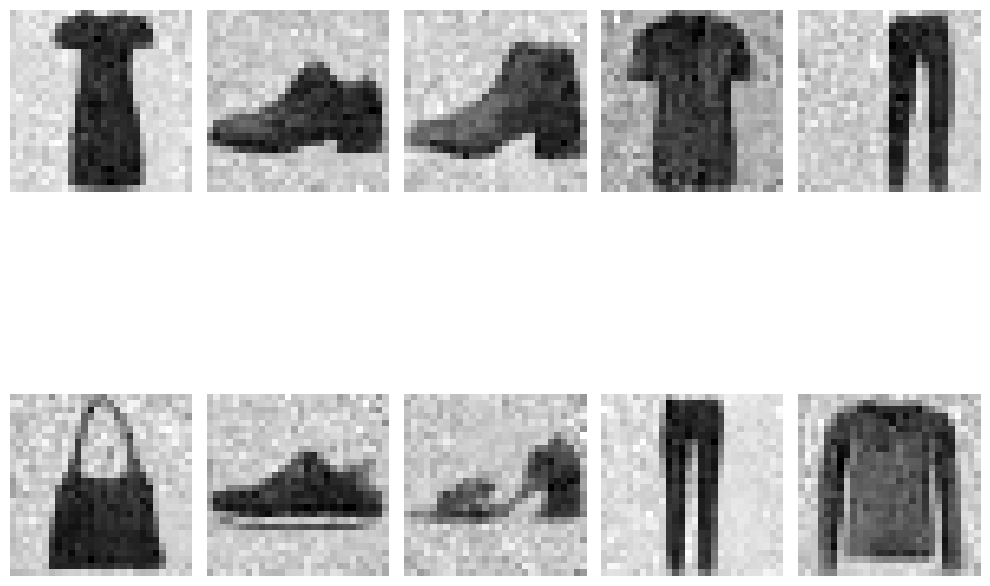

In [ ]:
# 10 Best Samples

num_images = 300
img = sample(model, (num_images, 1, 28, 28) )
imgs_to_keep = [0, 3, 23, 51, 295, 184,78, 80, 64, 269]

fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Display each image
for i, idx in enumerate(imgs_to_keep):
    row = i // 5
    col = i % 5
    selected_image = img[299][idx]  # Extract the selected image
    axes[row, col].imshow(selected_image.squeeze(), cmap='binary')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


**Interpretation results**

**How do diffussion models learn?**

In essence, diffusion models learn by reversing the diffusion of data. In our context, data diffusion entails the iterative addition of noise to an image. Once trained effectively, the model should generate high-resolution images from input consisting solely of white noise.

Crucially, the noise is added via a Markov chain during the forward process. This process renders the task of reversing noise addition tractable. Formally, noise addition through a fixed Markov process enables the approximation of posterior distribution of pixels in noisy images at each timestep. This posterior distribution results from the product of successive single-step conditional distributions, as shown below.

$$
q(x_{1:T}|x_0) = \overset{T}{\underset{t=1}{∏}}q(x_{t} | x_{t-1})
$$

In the continuous setting, these conditional distributions can be parameterised as the Gaussian shown below,

$$
q(x_t|x_{t-1}) ∼ N(\sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}\textbf{I})
$$

Where the $\beta_t$ follow a fixed schedule and are restricted to $[0,1]$, hence the mean of every new Gaussian gets closer and closer to zero.

Recalling the reparamaterisation used earlier where and $\alpha_{t} = 1 - \beta_t$ and $\bar \alpha_{t} = \overset{t}{\underset{s=1}{∏}} \alpha_s$, it follows that,

$$
q(x_t|x_0) \sim N(x_t; \sqrt{\bar \alpha_t}x_0, (1- \bar\alpha_t)\textbf{I}
$$

Thus, it can be easily seen that $q(x_T | x_0) \sim N(0,1)$ as $T \to ∞$.

Furthermore, *Feller, W., 2015* show that for infinitesimally small step size, the true distribution in the reverse process (described below) will be of the same functional form as the posterior distributions shown above. This allows us to parameterised the target distributions in the reverse process as unimodal Gaussians.

Formally, the distributions attained in the reverse process are of the form,

$$
p_{\theta}(x_{0:T}) = p(x_T)\overset{T}{\underset{t=1}{∏}}p_{\theta}(x_{t-1} | x_t)
$$

Where $p(x_{T}) \sim N(x_{T}; 0, I)$ i.e. it follows a Gaussian noise distribution.

In models that use latent variables, the evidence lower bound is commonly used to define loss functions between distributions. As shown by *Ho, J., Jain, A. and Abbeel, P., 2020.*, a simplified loss function can be derived from the evidence lower bound and the reparameterisation mentioned above. The loss function becomes,

$$
L_{simple}(\theta) = E_{t,x_0,\epsilon_{true}}[|| \epsilon_{true}-\epsilon_{predicted} ||^{2}]
$$

In training, the model endeavors to remove noise from an image to reconstruct the image from the corresponding previous time step in the forward pass. Typically, the image is processed through a convolutional neural network (CNN) and then compared to the original noisy image from the forward process in the loss function. In our case, we make use of the UNet which, as mentioned earlier, makes use of down and up sampling blocks to encode and decode the inputted image to produce the image in the previous step. The model is trained subject to the simplified loss function mentioned above.


***What specific modifications did I make?***

There are two key architectural changes I made to the base model to improve performance;

*1. Attention*

In the original model, the outputs of the down sample blocks are concatenated to the input of the corresponding block on the up sampling side of the layer.

This technique aims to retain spatial information during upsampling. As images are downsampled and upsampled, we lose information about the original location of each convolved pixel. By concatenating earlier layers with later ones, we mitigate this loss of spatial information.

An improvement to this feature, as explored by *Oktay, O., 2018*, involves adding an attention block. This block calculates attention between the outputs of the down blocks and the pre-transformation outputs of the up blocks. The resulting output is then concatenated onto the input of the next up block.

The rationale for this comes from deeper blocks containing more feaure wise information as a result of convolutions and downsampling, while earlier blocks retain more spatial information. Incorporating attention allows the model to dynamically emphasize or de-emphasize areas of greater or lesser relevance, enhancing its expressive power.


*2. Residual UNet*

In each block, I introduced a residual or 'skip' connection. This connection takes the input to a block, passes it through a 1x1 convolutional layer with same padding and then adds the output to the output of the two original convolutional layers before activation.

This setup compels the two convolutional layers in the original block to learn to model the residuals of the desired output, as we add the original input right after.

The goal of this to avoid issues of vanishing or exploding gradients in backpropagation in deep neural networks where gradients are miultiplied consecutively. This is achieved through skip connections since gradients need not flow through the intermediate layers, thus perserving their magnitudes.

***How does the model perform?***

The final model I opted for was one which followed the architecure described above with the following configuration:

- Number of Down/Up Blocks; 2
- Channels; (26, 52)
- Time Embedding Dimension; 16

This amassed a total of 487918 parameters. I trained the model for 30 epochs.

As expected each epoch, the model exhibited gradual improvement in its ability to accurately denoise pure noise images and generate fashion items.

In the first visualization, model weights were saved every five epochs. For each saved model, the same pure noise input was passed, and the denoised image was plotted at ten equally spaced timesteps, culminating in the final (300th) image for each model. Clearly, the quality of image generation improved over the training period. Notably, the output transformed from an amorphous shape after one epoch to a clearly discernible boot after thirty epochs.

In the second plot below, I feed the fully trained model 10 different pure noise images. For each noise, I plot the output of the model after every 20 timesteps, where each column corresponds to a different inputted noise. This plot revealed the model's tendency to generate images with distinct silhouettes like shoes and shirts more readily than complex shapes such as handbags.

One reason for this is likely due to the images of handbags in the training dataset having more varying shapes than say shoes, which all look quite similar. Thus making it difficult for the model to learn to replicate one of these images.

Secondly, the model's representational capacity, in terms of the number of parameters, might be insufficient to capture the nuanced shapes of handbags. Increasing the model's depth and granularity of feature maps could potentially address this limitation.

Lastly, despite efforts to preserve spatial information during training, the model may still struggle to generate images with varying orientations or scales not encountered in the training dataset, limiting its generalization capability in producing such images.

sampling loop time step: 100%|██████████| 300/300 [00:06<00:00, 45.93it/s]


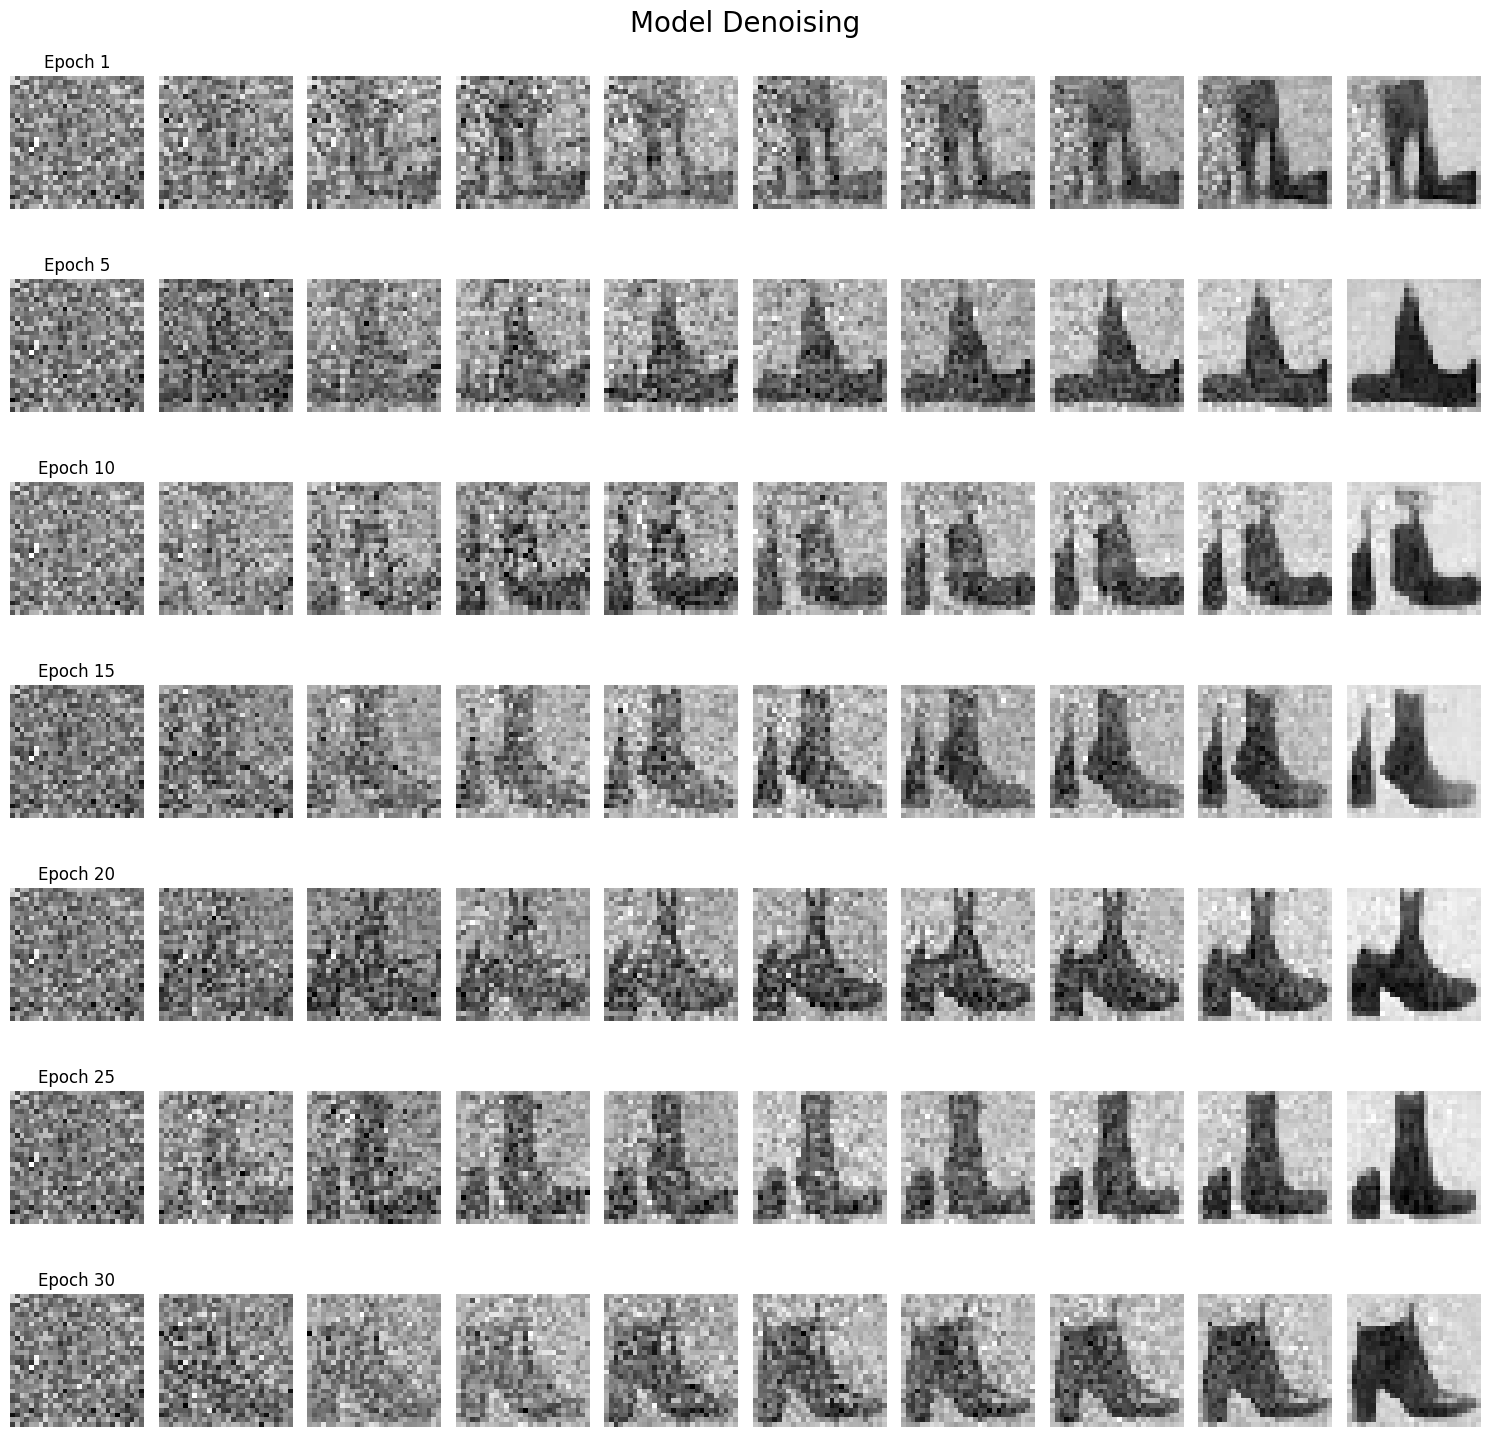

In [ ]:
# Altering the usual sample function to take a gaussian noise as input
@torch.no_grad()
def sample_2(model, shape, noisy_img):

    device = next(model.parameters()).device
    noisy_img = noisy_img.to(device)

    b = shape[0]
    # start from pure noise (for each example in the batch)
    # img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        noisy_img = sample_timestep(model, noisy_img, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas)
        imgs.append(noisy_img.cpu().numpy())

    return imgs

# Model weight directoy
weight_files = os.listdir(model_dir)
weight_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
imgs_to_keep = np.linspace(0,299, 10, dtype=int).tolist()

# Generate random noise to pass in to each model
noisy_img = torch.randn((1,1,28,28))


fig, axes = plt.subplots(len(weight_files), len(imgs_to_keep), figsize=(15, 15))

for row, weight_file in enumerate(weight_files):
  imgs = []

  # Load model and weights
  model = SimpleUnet_Residual(d_channels, u_channels, t_e)  # Assuming SimpleUnet is defined
  load_model_weights(model, os.path.join(model_dir, weight_file))

  # Generate Sample
  img = sample_2(model, (1, 1, 28, 28), noisy_img)

  #Adding title
  axes[row, 0].set_title( f"Epoch { int(weight_file.split('_')[-1].split('.')[0])+1}" , fontsize=12 )

  for col, img_idx in enumerate(imgs_to_keep):
    axes[row, col].imshow(img[img_idx].reshape(28, 28), cmap="binary")
    axes[row, col].axis('off')  # Turn off axis

plt.suptitle("Model Denoising", fontsize=20)
plt.tight_layout()    # Adjust layout to prevent overlapping
plt.show()

sampling loop time step: 100%|██████████| 300/300 [00:43<00:00,  6.90it/s]


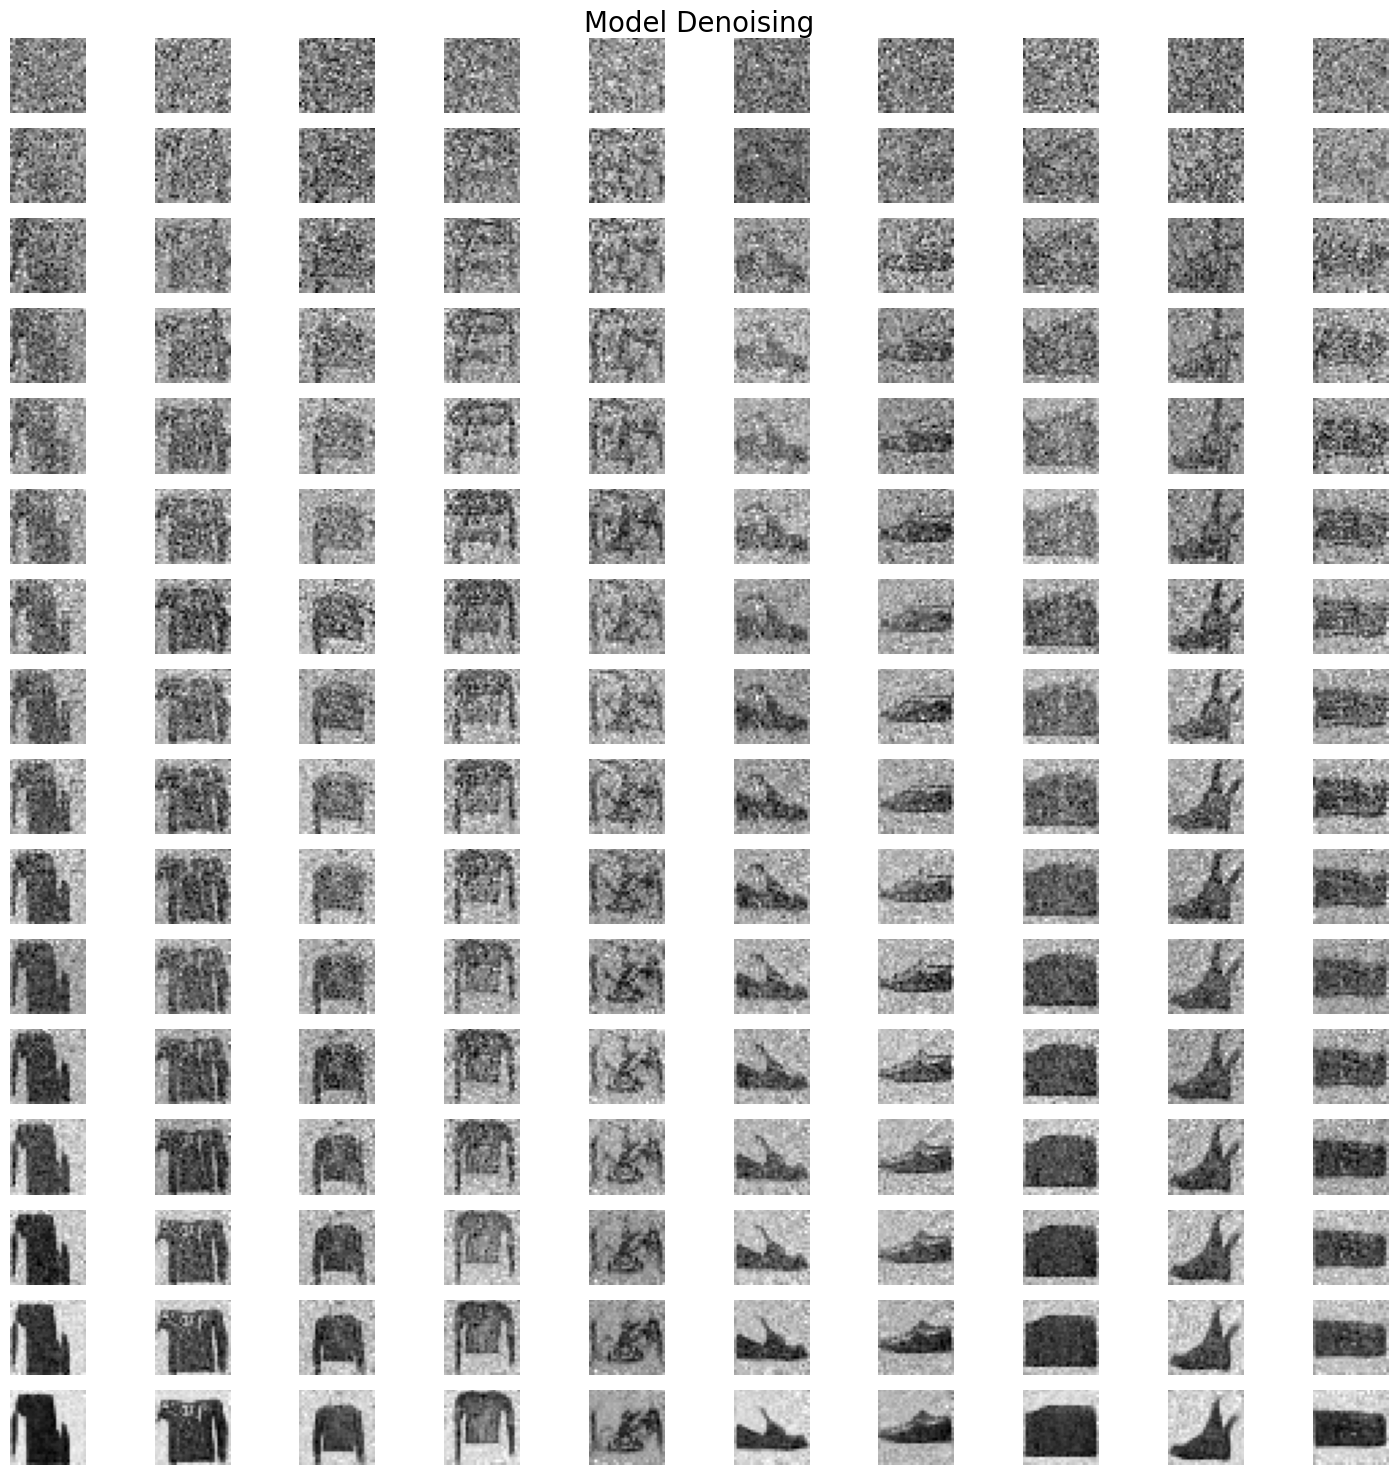

In [ ]:
# UNet with Attention and Residuals

img = sample(model, (10, 1, 28, 28) )

num_rows = [i for i in range(0, len(img), 20)]
num_rows.append(299)
num_cols = 10  # Assuming there are 10 images in each list

fig, axes = plt.subplots(len(num_rows), num_cols, figsize=(15, 15))

# Plot each image

for i, row in enumerate(num_rows):
    for j in range(num_cols):
        axes[i, j].imshow(img[row][j].reshape(28, 28), cmap = 'binary')
        axes[i, j].axis('off')  # Turn off axis

plt.suptitle("Model Denoising", fontsize=20)
plt.tight_layout()    # Adjust layout to prevent overlapping
plt.show()